## Лабораторная работа №1

In [1]:
!pip install ogb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.4 MB/s eta 0:00:00


In [2]:
import networkx as nx
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from collections import Counter
import random
import os
from ogb.graphproppred import GraphPropPredDataset
from collections import defaultdict

random.seed(0)
np.random.seed(0)

## Найти или сгенерировать набор данных для бинарной классификации графов.


In [3]:
'''Загрузка датасета'''

# dataset = LinkPropPredDataset(name='ogbl-ppa')

# https://best-of-web.builder.io/library/snap-stanford/ogb
data = GraphPropPredDataset(name='ogbg-molhiv')
labels = data.labels.flatten()

# посмотрим распределение целевой переменной
print(f"Класс 0: {len(labels[labels == 0])}")
print(f"Класс 1: {len(labels[labels == 1])}")

# Преобразуем edge_index в граф networkx
def convert_to_graph(edge_index):
    edges = list(zip(edge_index[0], edge_index[1]))
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

graphs = [convert_to_graph(graph['edge_index']) for graph, _ in data]

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:01<00:00, 31456.02it/s]


Saving...
Класс 0: 39684
Класс 1: 1443


Для представителя класса 0:

Свойства первых 3 узлов:
 [[5 0 4 5 3 0 2 0 0]
 [5 0 4 5 2 0 2 0 0]
 [5 0 3 5 0 0 1 0 1]]
Свойства первых 3 рёбер:
 [[0 0 0]
 [0 0 0]
 [0 0 0]]


Для представителя класса 1:

Свойства первых 3 узлов:
 [[7 0 1 5 0 0 1 0 0]
 [5 0 3 5 0 0 1 0 0]
 [7 0 2 5 1 0 1 0 0]]
Свойства первых 3 рёбер:
 [[1 0 1]
 [1 0 1]
 [0 0 1]]


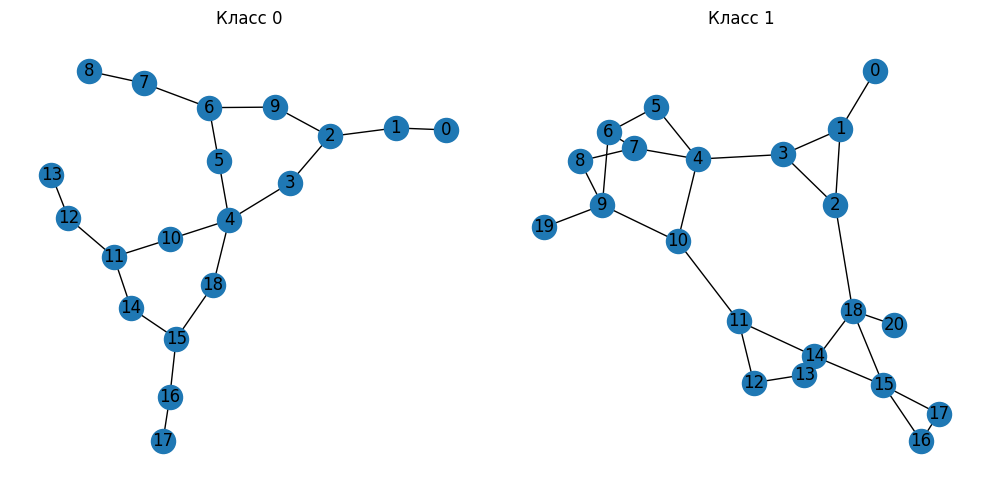

In [4]:
'''Визуализация по одному из графов каждого класса'''
############## класс 0
# первый граф с лейблом 0
print('Для представителя класса 0:\n')
graph1_0 = data[np.where(labels == 0)[0][0]][0]

# Свойства узлов и рёбер (по 3 узла и ребра)
node_feat0, edge_feat0 = graph1_0['node_feat'], graph1_0['edge_feat']
print(f"Свойства первых 3 узлов:\n {node_feat0[:3]}")
print(f"Свойства первых 3 рёбер:\n {edge_feat0[:3]}")

edges0 = list(zip(graph1_0['edge_index'][0], graph1_0['edge_index'][1]))
Graph1_0 = nx.Graph()
Graph1_0.add_edges_from(edges0)
# nx.draw(Graph1_0, with_labels=True)

#################### класс 1
# первый граф с лейблом 0
print('\n\nДля представителя класса 1:\n')
graph1_1 = data[np.where(labels == 1)[0][0]][0]

# Свойства узлов и рёбер (по 3 узла и ребра)
node_feat1, edge_feat1 = graph1_1['node_feat'], graph1_1['edge_feat']
print(f"Свойства первых 3 узлов:\n {node_feat1[:3]}")
print(f"Свойства первых 3 рёбер:\n {edge_feat1[:3]}")

edges_1 = list(zip(graph1_0['edge_index'][0], graph1_1['edge_index'][1]))
Graph1_1 = nx.Graph()
Graph1_1.add_edges_from(edges_1)
# nx.draw(Graph1_1, with_labels=True)

# Рисуем оба графика на одном изображении
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

nx.draw(Graph1_0, with_labels=True, ax=axes[0])
axes[0].set_title('Класс 0')

nx.draw(Graph1_1, with_labels=True, ax=axes[1])
axes[1].set_title('Класс 1')

plt.tight_layout()
plt.show()

## Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`
 которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными


In [5]:
# Граф -> вектор кратчейших путей
def graph_to_shortest_path_vector(graph):
    '''вычисление длины кратчайших путей между всеми парами узлов в графе'''
    path_lengths = dict(nx.shortest_path_length(graph))

    '''max длина кратчайшего пути'''
    max_length = max(max(lengths.values()) for lengths in path_lengths.values() if lengths)

    '''вектор кратчайших путей: индекс = длина пути, значение = количество путей такой длины'''
    # инициализация
    path_vector = np.zeros(max_length + 1)
    # заполнение
    for lengths in path_lengths.values():
        for length in lengths.values():
            path_vector[length] += 1

    return path_vector


def shortest_path_kernel(train_graphs, test_graphs):
    '''все графы --> вектора кратчайших путей'''
    train_vectors = [graph_to_shortest_path_vector(g) for g in train_graphs]
    test_vectors = [graph_to_shortest_path_vector(g) for g in test_graphs]

    '''Все имеющиеся векторы (train и test) приведем к одинаковой длине, заполнив недостающие данные нулями'''
    max_len = max(
                  max(len(vect) for vect in train_vectors),
                  max(len(vect) for vect in test_vectors)
                  )

    train_vectors = np.array([np.pad(v, (0, max_len - len(v))) for v in train_vectors])
    test_vectors = np.array([np.pad(v, (0, max_len - len(v))) for v in test_vectors])

    '''расчет матрицы из ядровых функций'''
    K_train, K_test = np.dot(train_vectors, train_vectors.T), np.dot(test_vectors, train_vectors.T)

    return K_train, K_test


In [6]:
'''Отбираем по 1443 объектов каждого класса (всего 1443 объекта класса 1 => выберем так, чтобы было 50 на 50, баланс классов)'''
class0_inds, class1_inds = np.where(labels == 0)[0], np.where(labels == 1)[0]
class0_filtered, class1_filtered = class0_inds[:1443], class1_inds[:1443]

selected_inds = np.concatenate([class0_filtered, class1_filtered])
selected_graphs, selected_labels = [graphs[i] for i in selected_inds], labels[selected_inds]

'''train/test деление'''
train_graphs, test_graphs, y_train, y_test = train_test_split(selected_graphs, selected_labels, test_size=0.2, random_state=0)

'''Вычисление матриц ядровых функций'''
K_train1, K_test1 = shortest_path_kernel(train_graphs, test_graphs)

# print(K_train1.shape)
# print(K_test1.shape)


## Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества

In [7]:
#gridSearch по следующим гиперпаарметрами: параметр регуляризации, условие критерия остановки
parameters = {'C':[0.1, 0.5, 1, 3, 5, 10]}
model1 = SVC(kernel ='precomputed', random_state=0)
clf1 = GridSearchCV(model1, parameters, cv=3, verbose=2)
clf1.fit(K_train1, y_train)
clf1.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ..............................................C=0.1; total time=   5.4s
[CV] END ..............................................C=0.1; total time=   5.1s
[CV] END ..............................................C=0.1; total time=   4.5s
[CV] END ..............................................C=0.5; total time=  23.9s
[CV] END ..............................................C=0.5; total time=  15.7s
[CV] END ..............................................C=0.5; total time=  18.1s
[CV] END ................................................C=1; total time=  48.0s
[CV] END ................................................C=1; total time=  37.4s
[CV] END ................................................C=1; total time=  58.7s
[CV] END ................................................C=3; total time= 2.5min
[CV] END ................................................C=3; total time= 2.0min
[CV] END ........................................

{'C': 5}

In [8]:
#выберу лучшую модель согласно перебору и посчитаю метрики
best_model1 = SVC(kernel ='precomputed', random_state=0, **clf1.best_params_)
best_model1.fit(K_train1, y_train)
y_pred1 = list(best_model1.predict(K_test1))
print(f'Accuracy: {accuracy_score(y_test, y_pred1)}')
print(f'Precision: {precision_score(y_test, y_pred1)}')
print(f'Recall: {recall_score(y_test, y_pred1)}')

Accuracy: 0.6401384083044983
Precision: 0.6563876651982379
Recall: 0.5340501792114696


Результаты зафиксировали, теперь попробуем сравнить с Weisfeiler-Lehman Kernel.

## Также реализовать **Weisfeiler-Lehman Kernel** и обучить классификатор с ним, сравнить результаты


In [9]:
# функция для совершения шага алгоритма
def WeisfeilerLehman_step(graph, labels):
    new_labels = {}
    for node in graph.nodes():
        neighbors_labels = sorted([labels[neighbor] for neighbor in graph.neighbors(node)]) # отбор меток соседних узлов
        new_labels[node] = hash((labels[node], tuple(neighbors_labels))) # Обновление метки узла
    return new_labels


def WeisfeilerLehman_kernel(train_graphs, test_graphs, h=2):
    ''' Инициализация меток'''
    train_labels, test_labels = [{node: 1 for node in graph.nodes()} for graph in train_graphs], \
                                [{node: 1 for node in graph.nodes()} for graph in test_graphs]

    '''Инициализация словрей для хранения частот меток на каждой итерации'''
    train_label_freqs, test_label_freqs = [defaultdict(int) for i in range(len(train_graphs))], \
                                        [defaultdict(int) for i in range(len(test_graphs))]

    '''проведение h итераций обновления меток'''
    for _ in range(h):
        '''Обновление метки и подсчет частот для каждого тренировочного графа'''
        for i, graph in enumerate(train_graphs):
            train_labels[i] = WeisfeilerLehman_step(graph, train_labels[i])
            for label in train_labels[i].values():
                train_label_freqs[i][label] += 1
        '''Обновление метки и подсчет частот для каждого тестового графа'''
        for i, graph in enumerate(test_graphs):
            test_labels[i] = WeisfeilerLehman_step(graph, test_labels[i])
            for label in test_labels[i].values():
                test_label_freqs[i][label] += 1

    '''Инициализация K_train и K_test'''
    K_train, K_test = np.zeros((len(train_graphs), len(train_graphs))), \
                      np.zeros((len(test_graphs), len(train_graphs)))

    '''Непосредственно вычисление K_train и K_test (скалярное произведение частот меток) для тренировочных графов'''
    for i in range(len(train_graphs)):
        for j in range(i, len(train_graphs)):
            common_labels = set(train_label_freqs[i].keys()).intersection(train_label_freqs[j].keys())
            K_train[i, j] =  K_train[j, i] = sum(min(train_label_freqs[i][label], train_label_freqs[j][label]) for label in common_labels)

    '''Непосредственно вычисление K_train и K_test (скалярное произведение частот меток) для тестовых графов'''
    for i in range(len(test_graphs)):
        for j in range(len(train_graphs)):
            common_labels = set(test_label_freqs[i].keys()).intersection(train_label_freqs[j].keys())
            K_test[i, j] = sum(min(test_label_freqs[i][label], train_label_freqs[j][label]) for label in common_labels)

    return K_train, K_test


In [10]:
'''Вычисление матриц ядровых функций'''
K_train2, K_test2 = WeisfeilerLehman_kernel(train_graphs, test_graphs)

# print(K_train2.shape)
# print(K_test2.shape)

In [11]:
#gridSearch по следующим гиперпаарметрами: параметр регуляризации, условие критерия остановки
parameters = {'C':[0.1, 0.5, 1, 3, 5, 10]}
model2 = SVC(kernel ='precomputed', random_state=0)
clf2 = GridSearchCV(model2, parameters, cv=3, verbose=2)
clf2.fit(K_train2, y_train)
clf2.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.1s
[CV] END ..............................................C=0.5; total time=   0.1s
[CV] END ..............................................C=0.5; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=3; total time=   0.4s
[CV] END ................................................C=3; total time=   0.5s
[CV] END ........................................

{'C': 0.1}

In [12]:
#выберу лучшую модель согласно перебору и посчитаю метрики
best_model2 = SVC(kernel ='precomputed', random_state=0, **clf2.best_params_)
best_model2.fit(K_train2, y_train)
y_pred2 = list(best_model2.predict(K_test2))
print(f'Accuracy: {accuracy_score(y_test, y_pred2)}')
print(f'Precision: {precision_score(y_test, y_pred2)}')
print(f'Recall: {recall_score(y_test, y_pred2)}')

Accuracy: 0.7352941176470589
Precision: 0.7480314960629921
Recall: 0.6810035842293907


## Выводы:

1. Качество модели повысилось: значения метрик accuracy, precision и recall увеличились на 15-20%.
2. Обучение модели с Weisfeiler-Lehman Kernel происходило значительно быстрее.
